In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import folium
from pandasai import PandasAI

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet("dataframes/italy_housing_price_rent_raw.parquet.gzip")
df.head(3)

,prezzo,stanze,m2,bagni,piano,description,Riferimento e Data annuncio,contratto,tipologia,superficie,...,stato,riscaldamento,Climatizzatore,Efficienza energetica,Indice prest. energetica rinnovabile,Prestazione energetica del fabbricato,certificazione energetica,Emissioni di CO₂,spese aggiuntive,regione
16560,1.800/mese,3,60m²,1,"9°, con ascensore","Piazza San Camillo De Lellis, nella signorile ...",ADR9 - 07/03/2023,"Affitto, libero",Appartamento | Intera proprietà | Immobile di ...,60 m² | commerciale 68 m² - Vedi dettaglio,...,Ottimo / Ristrutturato,"Autonomo, a radiatori, alimentato a metano","Autonomo, freddo/caldo",E132.32 kWh/m² anno,None,invernale estivo,None,None,None,None
16561,450/mese,2,55m²,1,"5°, con ascensore","Zona SANTA RITA, precisamente su CORSO AGNELLI...",25481 - 07/03/2023,Affitto,Appartamento | Classe immobile media,55 m²,...,Ottimo / Ristrutturato,"Autonomo, a radiatori, alimentato a teleriscal...",None,E≥ 175 kWh/m² anno,None,None,None,None,None,None
16562,3.200/mese,5+,400m²,3+,"2°, con ascensore",Zona pedonale - Si propone in locazione import...,a.118 - 07/03/2023,Affitto,Appartamento | Intera proprietà | Classe immob...,400 m²,...,Ottimo / Ristrutturato,"Autonomo, a radiatori","Autonomo, freddo/caldo",E127.6 kWh/m² anno,None,None,None,None,None,None


In [3]:
# PRICE
df['prezzo'] = df['prezzo'].str.replace('€', '')
df['prezzo'] = df['prezzo'].str.replace(r'[^0-9]+', '')
df['prezzo'][df['prezzo'] == ''] = np.nan
df['prezzo'] = df['prezzo'].astype(float)

In [4]:
# GEOGRAPHIC INGO
df['regione'] = df['regione'].str.title()
df['citta'] = df['citta'].str.title()

In [5]:
# DATETIME INFO
from datetime import date
df = df.rename(columns={'Riferimento e Data annuncio': "data"})
date_regex = r'(\d{2}/\d{2}/\d{4})'
df['datetime'] = df['data'].str.extract(date_regex)
df['datetime'] = pd.to_datetime(df['datetime'])

today = np.datetime64(date.today())
df = df.loc[(df['datetime'] > '2023-01-01') & (df['datetime'] < today)]

In [6]:
df = df.dropna(subset=['regione', 'citta', 'prezzo'])

<AxesSubplot:>

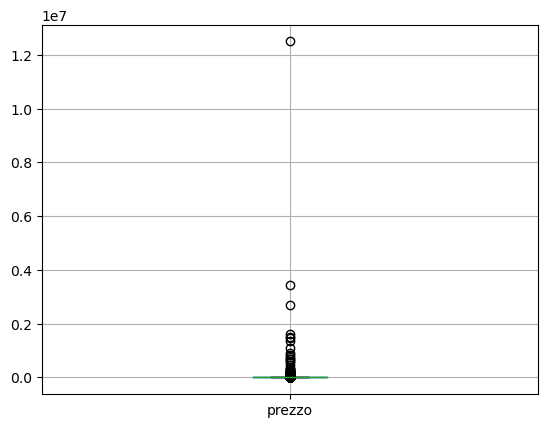

In [7]:
## CHECK OUTLIERS
df.boxplot(column=['prezzo'])

In [8]:
df = df.loc[df['prezzo'] < 5000]

## DISPLAY PRICES BY REGION 

Text(0, 0.5, 'Region')

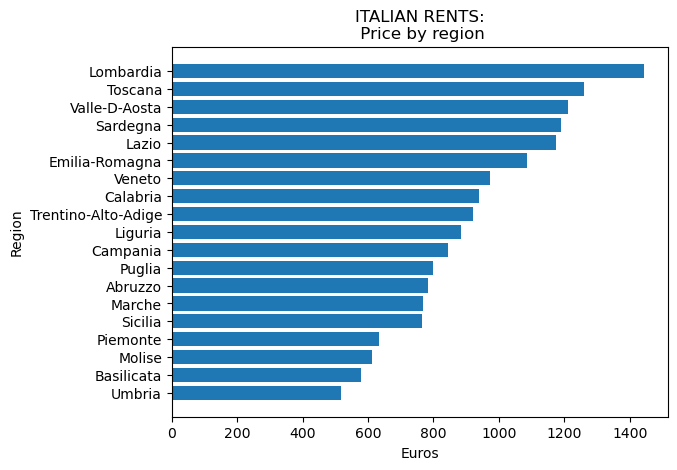

In [9]:
prices_by_region = df['prezzo'].groupby(df['regione']).mean().sort_values(ascending=True)

fig1, ax = plt.subplots()
ax.barh(prices_by_region.index, prices_by_region, )
ax.set_title("ITALIAN RENTS:\n Price by region")
ax.set_xlabel("Euros")
ax.set_ylabel("Region")

In [10]:
df_price = pd.DataFrame(prices_by_region)
df_price = df_price.reset_index()
df_price.columns = ['reg_name', 'prezzo']

In [11]:
italy = "data/limits_IT_regions.geojson"
geo_data = gpd.read_file(italy)
geo_data_region = geo_data.merge(df_price, on = 'reg_name')
geo_data_region['prezzo'] = round(geo_data_region['prezzo'].astype(float), 2)
geo_data_region

DriverError: data/limits_IT_regions.geojson: No such file or directory

In [ ]:
map = folium.Map(location=[41.8719, 12.5674], zoom_start=5)

folium.Choropleth(
    geo_data=geo_data_region,
    data=geo_data_region,
    columns=['reg_name', 'prezzo'],
    key_on='feature.properties.reg_name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Your Choropleth Title'
).add_to(map)


highlights = folium.features.GeoJson(
    geo_data_region,
    style_function= lambda x:
    {"color": "red",
     #"fillColor":"YlOrBr",
     "weight":1,
     "fillOpacity":0,
     },
    highlight_function = lambda x: {
        'fillColor': '#000000',
        'color': '#000000',
        'fillOpacity': 0.50,
        'weight': 0.5
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['reg_name' , 'prezzo'],
        aliases = [ 'REGION:' , 'Mean price in euro:' ],
        labels = True,
        sticky = False)
)

map.add_child(highlights)
map.keep_in_front(highlights)
folium.LayerControl().add_to(map)

#map

## PRICE BY CITY

In [ ]:
EXTREME_CASES = 10

price_by_city_mean = df['prezzo'].groupby(df['citta']).mean()
price_by_city = price_by_city_mean.sort_values(ascending=True)
price_by_city_extremes = pd.concat(
    [price_by_city.head(EXTREME_CASES),
     price_by_city.tail(EXTREME_CASES)],
    axis=0)

In [ ]:
fig1, ax = plt.subplots()
ax.barh(price_by_city_extremes.index, price_by_city_extremes)
ax.set_title("ITALIAN RENTS:\n Price by city")
ax.set_xlabel("Euros")
ax.set_ylabel("City")

In [ ]:
df_price = pd.DataFrame(price_by_city)
df_price = df_price.reset_index()
df_price.columns = ['name', 'prezzo']
df_price['prezzo'] = round(df_price['prezzo'].astype(float), 2)
df_price.loc[df_price['prezzo'] > 5000, 'prezzo'] = 5000

In [ ]:
italy = "data/limits_IT_municipalities.geojson"
geo_data = gpd.read_file(italy)
geodata_city = geo_data.merge(df_price, on='name')
geodata_city = geodata_city[['name', 'prezzo', 'geometry']]
geodata_city.head(3)

In [ ]:
map = folium.Map(location=[41.8719, 12.5674], zoom_start=4.8)

folium.Choropleth(
    geo_data=geodata_city,
    data=geodata_city,
    columns=['name', 'prezzo'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Price by municipality'
).add_to(map)

highlights = folium.features.GeoJson(
    geodata_city,
    style_function= lambda x:
    {#"color": "red",
     #"fillColor":"YlOrBr",
     "weight":0,
     "fillOpacity":0,
     },
    highlight_function = lambda x: {
        'fillColor': '#000000',
        'color': '#000000',
        'fillOpacity': 0.50,
        'weight': 0.5
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name' , 'prezzo'],
        aliases = [ 'REGION:' , 'Mean price in euro:' ],
        labels = True,
        sticky = False)
)

map.add_child(highlights)
map.keep_in_front(highlights)
folium.LayerControl().add_to(map)

#map

## TIME SERIES ANALYSIS

In [ ]:
# DATE TIME
df = df.rename(columns={'Riferimento e Data annuncio': "data"})
date_regex = r'(\d{2}/\d{2}/\d{4})'
df['datetime'] = df['data'].str.extract(date_regex)
df['datetime'] = pd.to_datetime(df['datetime'])


In [ ]:
## PRICE BY DATE
df['prezzo'].groupby(df['datetime']).mean().plot()

In [ ]:
# PRICE BY DATE AND REGION
north = ['Lombardia', 'Veneto', 'Piemonte', 'Valle-D-Aosta', 'Trentino-Alto-Adige', 'Friuli-venezia giulia']
center = ['Liguria', 'Toscana', 'Lazio', 'Marche', 'Umbria', 'Emilia-Romagna', 'Molise']
south = ['Campania', 'Puglia', 'Sicilia', 'Calabria', 'Basilicata', 'Abruzzo', 'Sardegna']

In [ ]:
def plot_prices(area):
    df_area = df[df['regione'].isin(area)]
    df_area['prezzo'] = df_area['prezzo'].fillna(method='ffill')
    price_area = df_area['prezzo'].groupby([df_area['datetime'], df_area['regione']]).mean().unstack()

    price_area.plot(
        figsize=(15, 10),
        title='Price by date and region',
        xlabel='Date',
        ylabel='Price',
        grid=True,
        legend=True,
        #colormap='tab20'
    )

In [ ]:
# line plot
plot_prices(north)

In [ ]:
plot_prices(center)

In [ ]:
plot_prices(south)

In [ ]:
## ALTRE CARATTERISTICHE FREQUENCY
DF = pd.read_parquet("dataframes/italy_housing_price_rent_raw.parquet.gzip")

def flatten(l):
    return [item for sublist in l for item in sublist]

c = X['altre caratteristiche'].to_list()
c = flatten(c)

freq = {}
counting = [freq.update({x: c.count(x)}) for x in c]
